In [41]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchinfo as torchinfo

from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model definition

In [3]:
class Net(nn.Module):
    def __init__(self, inp_channels=1, num_classes=10, batch_norm=True):
        super(Net, self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(inp_channels, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.pool1 = nn.MaxPool2d(2)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        if self.batch_norm:
            x = self.activation(self.bn1(self.conv1(x)))
            x = self.pool1(self.activation(self.bn2(self.conv2(x))))
        else:
            x = self.activation(self.conv1(x))
            x = self.pool1(self.activation(self.conv2(x)))
        x = self.dropout1(x).flatten(1)
        x = self.activation(self.fc1(x))
        x = self.fc2(self.dropout2(x))
        return x

### Dataset

In [4]:
# dataset_type = "CIFAR10"
dataset_type = "MNIST"

In [5]:
os.makedirs('./data', exist_ok=True)
if dataset_type == "MNIST":
    mnist_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=mnist_transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=mnist_transform)
else:
    cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=cifar_transform)
    test_dataset = datasets.CIFAR10('./data', train=False, transform=cifar_transform)

/opt/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Model Training

In [7]:
def train(model, optimizer, epoch, log=True, log_interval=100):
    model.train()
    epoch_loss = []
    for i, (inp, label) in enumerate(train_loader):
        inp = inp.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        out = model(inp)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if log and i % log_interval == 0:
            print("Epoch: {}, Batch: {}, Batch Loss: {:.4f}".format(epoch, i, loss.item()))
    
    return np.mean(epoch_loss), epoch_loss

### Model Testing

In [36]:
for i, (img, label) in enumerate(test_loader):
    print(img.size(), label.size())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [9]:
def test(model, epoch, log=True, log_interval=100):
    model.eval()
    num_correct = 0

    epoch_loss = []
    pred_list = []
    labels_list = []
    with torch.no_grad():
        for i, (inp, label) in enumerate(test_loader):
            inp = inp.to(device)
            label = label.to(device)

            out = model(inp)
            pred = torch.argmax(out, dim=1)
            loss = criterion(out, label)
            
            epoch_loss.append(loss.item())
            num_correct += torch.sum((pred == label)).item()
            
            pred_list.extend(list(pred.cpu().numpy()))
            labels_list.extend(list(label.cpu().numpy()))

    test_acc = num_correct / len(test_dataset)
    return test_acc, np.mean(epoch_loss), epoch_loss, pred_list, labels_list

#### Hyperparameter Tuning

In [10]:
criterion = nn.CrossEntropyLoss()
model1, model2, model3, model5, model6 = Net(), Net(), Net(), Net(), Net()
model4 = Net(batch_norm=False)

hyperparams = {
    "default": [SGD(model1.parameters(), lr=0.01), model1],
    "exp2": [SGD(model2.parameters(), lr=0.0001), model2],
    "exp3": [SGD(model3.parameters(), lr=0.01, momentum=0.8), model3],
    "exp4": [SGD(model4.parameters(), lr=0.01), model4],
    "exp5": [SGD(model5.parameters(), lr=0.01, weight_decay=0.01), model5],
    "exp6": [Adam(model6.parameters(), lr=0.01), model6]
}

### Run Epochs

In [11]:
def run_epochs(model, optimizer, criterion, epochs, model_name):
    best_acc = -1
    batch_train_losses, batch_test_losses = [], []
    for epoch in range(epochs):
        mean_train_loss, epoch_train_loss = train(model, optimizer, epoch)
        test_acc, mean_test_loss, epoch_test_loss, _, _ = test(model, epoch)
        
        batch_train_losses.extend(epoch_train_loss)
        batch_test_losses.extend(epoch_test_loss)
        
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(epoch, mean_train_loss, mean_test_loss, test_acc))
        print("-"*100)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), os.path.join("./models", "{}.pt".format(model_name)))
    
    print("Model Name: {}, Best Model Accuracy: {}".format(model_name, best_acc))
    return batch_train_losses, batch_test_losses

### Default Model

In [42]:
optimizer, model = hyperparams["default"]
model_name = "default"

start_time = time.time()
batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)
end_time = time.time()

Epoch: 0, Batch: 0, Batch Loss: 0.1478
Epoch: 0, Batch: 100, Batch Loss: 0.0297
Epoch: 0, Batch: 200, Batch Loss: 0.0503
Epoch: 0, Batch: 300, Batch Loss: 0.0642
Epoch: 0, Batch: 400, Batch Loss: 0.0405
Epoch: 0, Train Loss: 0.0717, Test Loss: 0.0394, Test Acc: 0.9874
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 0.0642
Epoch: 1, Batch: 100, Batch Loss: 0.0203
Epoch: 1, Batch: 200, Batch Loss: 0.1107
Epoch: 1, Batch: 300, Batch Loss: 0.0405
Epoch: 1, Batch: 400, Batch Loss: 0.0081
Epoch: 1, Train Loss: 0.0660, Test Loss: 0.0377, Test Acc: 0.9881
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 0.0841
Epoch: 2, Batch: 100, Batch Loss: 0.0201
Epoch: 2, Batch: 200, Batch Loss: 0.0672
Epoch: 2, Batch: 300, Batch Loss: 0.0693
Epoch: 2, Batch: 400, Batch Loss: 0.0189
Epoch: 2, Train Loss: 0.0609, Test Loss: 0.0346, Test Acc

NameError: name 'start' is not defined

In [43]:
print("Total training time: {}".format(end_time - start_time))

Total training time: 564.7414491176605


##### Confusion Matrix & Training Curves

In [44]:
start_time = time.time()
test_acc, _, _, preds, labels = test(model, 0)
end_time = time.time()
print("Total time: {}".format(end_time - start_time))

Total time: 6.850646734237671


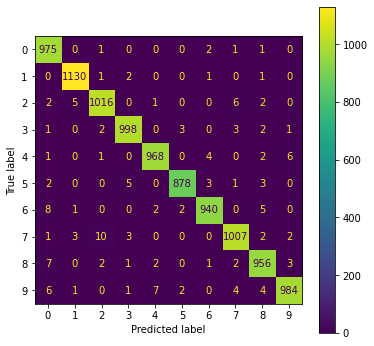

In [14]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

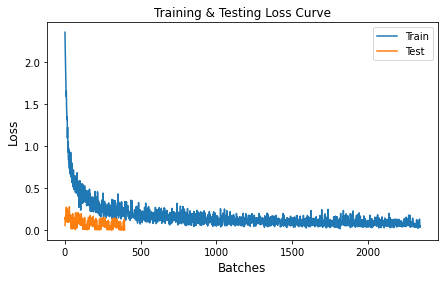

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")

#### Default Model Summary

In [38]:
torchinfo.summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─BatchNorm2d: 1-2                       [1, 32, 26, 26]           64
├─ReLU: 1-3                              [1, 32, 26, 26]           --
├─Conv2d: 1-4                            [1, 64, 24, 24]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 24, 24]           128
├─ReLU: 1-6                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-7                         [1, 64, 12, 12]           --
├─Dropout: 1-8                           [1, 64, 12, 12]           --
├─Linear: 1-9                            [1, 128]                  1,179,776
├─ReLU: 1-10                             [1, 128]                  --
├─Dropout: 1-11                          [1, 128]                  --
├─Linear: 1-12                           [1, 10]                   1,290

### Experiment 2

In [16]:
optimizer, model = hyperparams["exp2"]
model_name = "exp2"

batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)

Epoch: 0, Batch: 0, Batch Loss: 2.3754
Epoch: 0, Batch: 100, Batch Loss: 2.2370
Epoch: 0, Batch: 200, Batch Loss: 2.1162
Epoch: 0, Batch: 300, Batch Loss: 1.9868
Epoch: 0, Batch: 400, Batch Loss: 1.9418
Epoch: 0, Train Loss: 2.1040, Test Loss: 1.7864, Test Acc: 0.7284
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 1.8635
Epoch: 1, Batch: 100, Batch Loss: 1.7601
Epoch: 1, Batch: 200, Batch Loss: 1.7120
Epoch: 1, Batch: 300, Batch Loss: 1.6434
Epoch: 1, Batch: 400, Batch Loss: 1.5101
Epoch: 1, Train Loss: 1.6749, Test Loss: 1.3417, Test Acc: 0.8056
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 1.4582
Epoch: 2, Batch: 100, Batch Loss: 1.4931
Epoch: 2, Batch: 200, Batch Loss: 1.2759
Epoch: 2, Batch: 300, Batch Loss: 1.2853
Epoch: 2, Batch: 400, Batch Loss: 1.3014
Epoch: 2, Train Loss: 1.3499, Test Loss: 1.0400, Test Acc

##### Confusion Matrix & Training Curves

In [17]:
test_acc, _, _, preds, labels = test(model, 0)

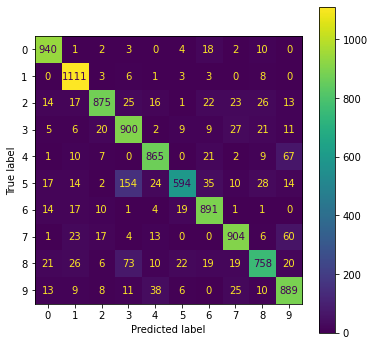

In [18]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

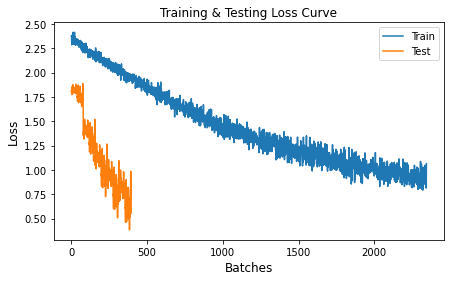

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")

### Experiment 3

In [20]:
optimizer, model = hyperparams["exp3"]
model_name = "exp3"

batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)

Epoch: 0, Batch: 0, Batch Loss: 2.3471
Epoch: 0, Batch: 100, Batch Loss: 0.2500
Epoch: 0, Batch: 200, Batch Loss: 0.1695
Epoch: 0, Batch: 300, Batch Loss: 0.1106
Epoch: 0, Batch: 400, Batch Loss: 0.1018
Epoch: 0, Train Loss: 0.2483, Test Loss: 0.0575, Test Acc: 0.9817
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 0.0720
Epoch: 1, Batch: 100, Batch Loss: 0.0897
Epoch: 1, Batch: 200, Batch Loss: 0.0775
Epoch: 1, Batch: 300, Batch Loss: 0.0857
Epoch: 1, Batch: 400, Batch Loss: 0.1004
Epoch: 1, Train Loss: 0.0963, Test Loss: 0.0394, Test Acc: 0.9869
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 0.0764
Epoch: 2, Batch: 100, Batch Loss: 0.1116
Epoch: 2, Batch: 200, Batch Loss: 0.0898
Epoch: 2, Batch: 300, Batch Loss: 0.0886
Epoch: 2, Batch: 400, Batch Loss: 0.1211
Epoch: 2, Train Loss: 0.0767, Test Loss: 0.0352, Test Acc

##### Confusion Matrix & Training Curves

In [21]:
test_acc, _, _, preds, labels = test(model, 0)

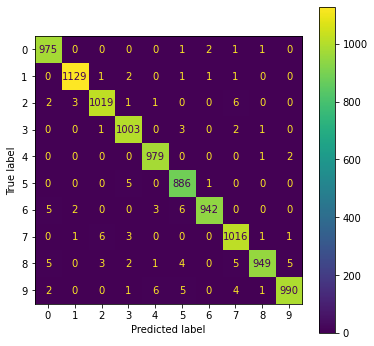

In [22]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

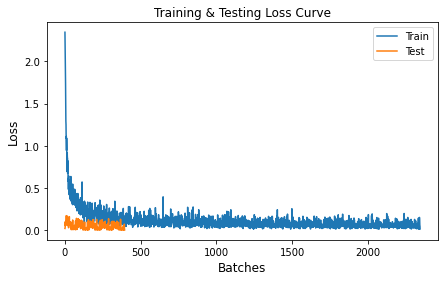

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")

### Experiment 4

In [24]:
optimizer, model = hyperparams["exp4"]
model_name = "exp4"

batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)

Epoch: 0, Batch: 0, Batch Loss: 2.3001
Epoch: 0, Batch: 100, Batch Loss: 0.7163
Epoch: 0, Batch: 200, Batch Loss: 0.5241
Epoch: 0, Batch: 300, Batch Loss: 0.5835
Epoch: 0, Batch: 400, Batch Loss: 0.3800
Epoch: 0, Train Loss: 0.6753, Test Loss: 0.2542, Test Acc: 0.9256
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 0.3733
Epoch: 1, Batch: 100, Batch Loss: 0.3827
Epoch: 1, Batch: 200, Batch Loss: 0.3292
Epoch: 1, Batch: 300, Batch Loss: 0.3256
Epoch: 1, Batch: 400, Batch Loss: 0.4822
Epoch: 1, Train Loss: 0.3301, Test Loss: 0.1881, Test Acc: 0.9433
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 0.2290
Epoch: 2, Batch: 100, Batch Loss: 0.3572
Epoch: 2, Batch: 200, Batch Loss: 0.2834
Epoch: 2, Batch: 300, Batch Loss: 0.3252
Epoch: 2, Batch: 400, Batch Loss: 0.2087
Epoch: 2, Train Loss: 0.2702, Test Loss: 0.1463, Test Acc

##### Confusion Matrix & Training Curves

In [25]:
test_acc, _, _, preds, labels = test(model, 0)

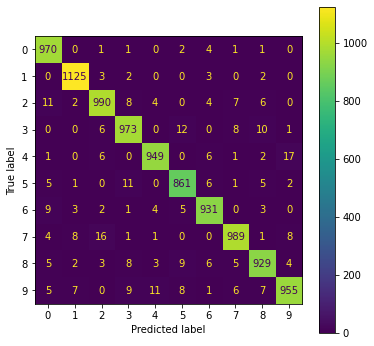

In [26]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

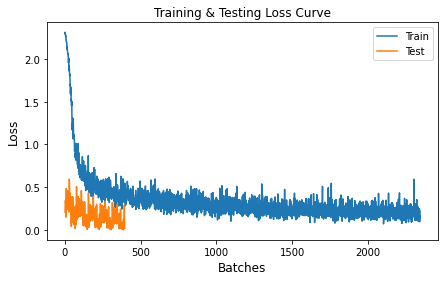

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")

### Experiment 5

In [28]:
optimizer, model = hyperparams["exp5"]
model_name = "exp5"

batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)

Epoch: 0, Batch: 0, Batch Loss: 2.3692
Epoch: 0, Batch: 100, Batch Loss: 0.4336
Epoch: 0, Batch: 200, Batch Loss: 0.4136
Epoch: 0, Batch: 300, Batch Loss: 0.2720
Epoch: 0, Batch: 400, Batch Loss: 0.1840
Epoch: 0, Train Loss: 0.4050, Test Loss: 0.1160, Test Acc: 0.9685
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 0.1210
Epoch: 1, Batch: 100, Batch Loss: 0.1521
Epoch: 1, Batch: 200, Batch Loss: 0.1834
Epoch: 1, Batch: 300, Batch Loss: 0.1660
Epoch: 1, Batch: 400, Batch Loss: 0.0721
Epoch: 1, Train Loss: 0.1570, Test Loss: 0.0739, Test Acc: 0.9781
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 0.1115
Epoch: 2, Batch: 100, Batch Loss: 0.1363
Epoch: 2, Batch: 200, Batch Loss: 0.1092
Epoch: 2, Batch: 300, Batch Loss: 0.1265
Epoch: 2, Batch: 400, Batch Loss: 0.1715
Epoch: 2, Train Loss: 0.1178, Test Loss: 0.0616, Test Acc

##### Confusion Matrix & Training Curves

In [29]:
test_acc, _, _, preds, labels = test(model, 0)

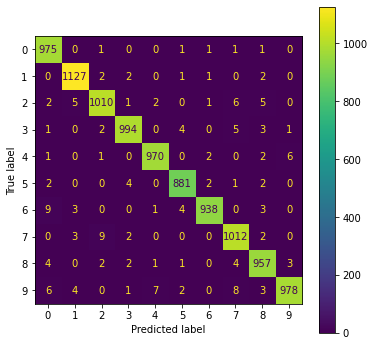

In [30]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

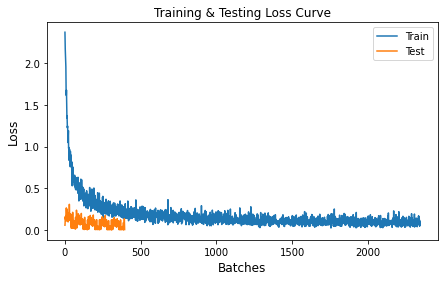

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")

### Experiment 6

In [32]:
optimizer, model = hyperparams["exp6"]
model_name = "exp6"

batch_train_losses, batch_test_losses = run_epochs(model, optimizer, criterion, 5, model_name)

Epoch: 0, Batch: 0, Batch Loss: 2.3864
Epoch: 0, Batch: 100, Batch Loss: 1.2455
Epoch: 0, Batch: 200, Batch Loss: 1.0470
Epoch: 0, Batch: 300, Batch Loss: 0.7742
Epoch: 0, Batch: 400, Batch Loss: 0.9477
Epoch: 0, Train Loss: 1.1544, Test Loss: 0.1171, Test Acc: 0.9724
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Batch Loss: 0.5770
Epoch: 1, Batch: 100, Batch Loss: 0.6660
Epoch: 1, Batch: 200, Batch Loss: 0.5863
Epoch: 1, Batch: 300, Batch Loss: 0.4585
Epoch: 1, Batch: 400, Batch Loss: 0.3629
Epoch: 1, Train Loss: 0.5285, Test Loss: 0.0802, Test Acc: 0.9798
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Batch Loss: 0.4845
Epoch: 2, Batch: 100, Batch Loss: 0.2914
Epoch: 2, Batch: 200, Batch Loss: 0.2845
Epoch: 2, Batch: 300, Batch Loss: 0.4120
Epoch: 2, Batch: 400, Batch Loss: 0.2944
Epoch: 2, Train Loss: 0.3685, Test Loss: 0.0619, Test Acc

##### Confusion Matrix & Training Curves

In [33]:
test_acc, _, _, preds, labels = test(model, 0)

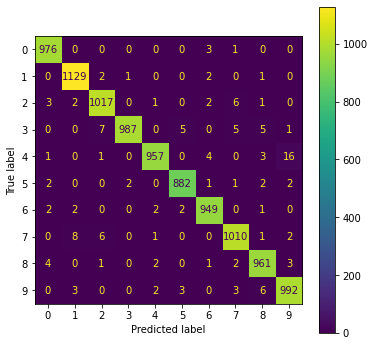

In [34]:
mnist_labels = [i for i in range(10)]
cm = confusion_matrix(labels, preds, labels=mnist_labels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Text(0, 0.5, 'Loss')

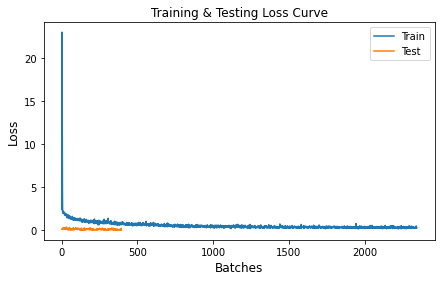

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(list(range(len(batch_train_losses))), batch_train_losses, label='Train')
ax.plot(list(range(len(batch_test_losses))), batch_test_losses, label='Test')

ax.legend()
ax.set_title('Training & Testing Loss Curve')
ax.set_xlabel('Batches', size="large")
ax.set_ylabel('Loss', size="large")